# Lab 1 Part 2: Music Generation with RNNs

In this portion of the lab, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music.

In [ ]:
# If you are using Google Colab
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/cosmin/Laboratory 01/'

In [ ]:
# Import all remaining packages
import numpy as np
import os
import time
import functools
import torch
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1

!pip install torchviz
!pip install torchinfo
import utils


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "[FAIL] No GPU found"

## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


In [ ]:
# Download the dataset
songs = utils.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

We can easily convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
utils.lab1.play_song(example_song)

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''
def vectorize_string(string):
  # TODO
  vectorized_output = np.zeros(len(string))

  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
print('You should obtain the following output:\n\'X:1\\nT:Alex\' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]')
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".


To illustrate this process with a concrete example, let’s consider a vectorized_songs array containing the values [49, 22, 13, 0, 45, 22, 26, 67, 60, 79] and set seq_length to 4.

Imagine we randomly choose a starting index of 2 to generate an input-target pair. Starting from index 2, we extract the next seq_length values as the input sequence, which gives us [13, 0, 45, 22]. The corresponding target sequence is obtained by shifting one position to the right, starting from index 3 and containing the same number of elements as the input. Thus, the target sequence is [0, 45, 22, 26].

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  # input_batch = # TODO
  input_batch = []
  '''TODO: construct a list of output sequences for the training batch'''
  # output_batch = # TODO
  output_batch = []

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not utils.lab1.test_batch_func_types(get_batch, test_args) or \
   not utils.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not utils.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

Three layers are used to define the model:

* [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`torch.nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html): Our LSTM network, with size `units=rnn_units`.
* [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): The output layer, with `vocab_size` outputs.


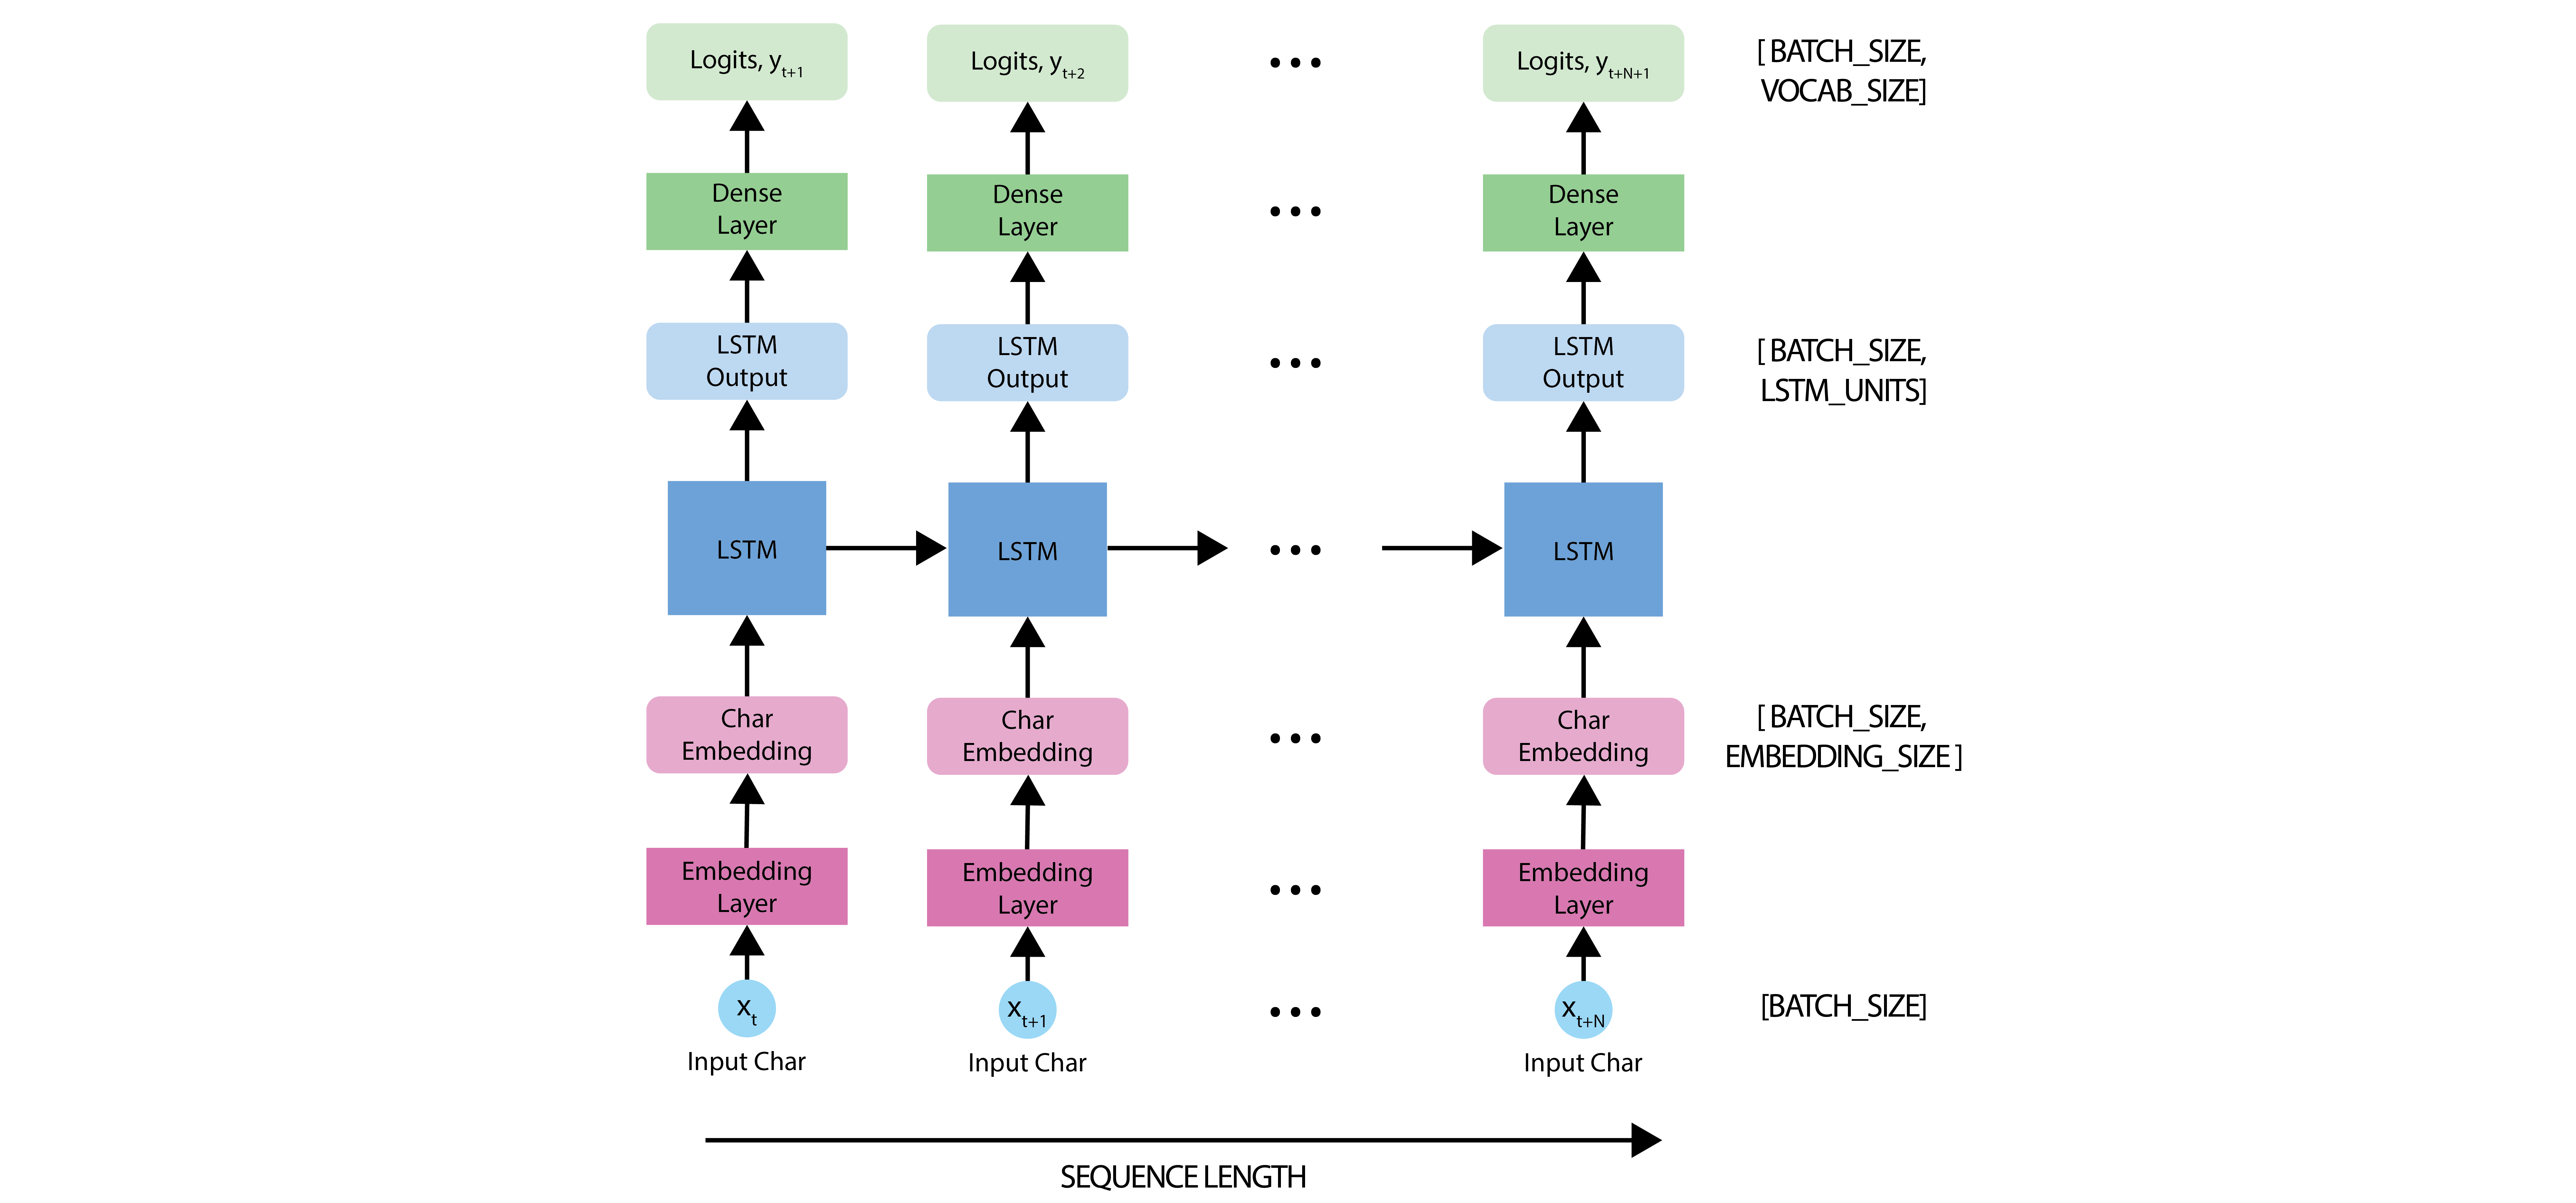

### Define the RNN model

Now, we will define our custom LSTM layer. We define a custom LSTM layer to explicitly control aspects like state initialization and processing, allowing the LSTM to maintain states across batches. Additionally, a custom layer gives flexibility to modify the LSTM's behavior or add functionality if needed, which can be beneficial in complex models.

In [ ]:
# class MyLSTM(torch.nn.Module):
#     def __init__(self, input_size, rnn_units):
#         super(MyLSTM, self).__init__()
#         self.lstm = torch.nn.LSTM(
#             input_size=input_size,
#             hidden_size=rnn_units,
#             batch_first=True
#         )

#     def forward(self, x, states=None):
#         # If states are None, initialize them
#         if states is None:
#             h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)  # Initial hidden state
#             c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)  # Initial cell state
#             states = (h0, c0)

#         out, states = self.lstm(x, states)
#         return out, states

def LSTM(embedding_dim, rnn_units):
  return torch.nn.LSTM(
      embedding_dim,
      rnn_units,
      num_layers = 1,
      batch_first=True)

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model.'''
class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_units, batch_size):
        super(RNNModel, self).__init__()
        self.batch_size = batch_size
        self.rnn_units = rnn_units

        # Layer 1: Embedding layer
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        # Layer 2: LSTM layer
        # self.lstm = MyLSTM(input_size=embedding_dim, rnn_units=rnn_units)
        self.lstm = LSTM(embedding_dim, rnn_units)

        # Layer 3: Dense (fully connected) layer
        self.fc = torch.nn.Linear(rnn_units, vocab_size)

    def forward(self, x, states=None):
        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        '''TODO: Add the embedding layer  '''

        # Layer 2: LSTM
        '''TODO: Add the custom LSTM layer defined above '''
        x, states = self.lstm(x, states)

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size.
        '''TODO: DENSE LAYER HERE'''


        return x, states

# From this point forward, it's essential to pay close attention to the device
# (CPU or GPU) on which you are running the code. Both the data and the model
# must be placed on the same device to ensure smooth execution. Failing to do so
# will lead to errors, as operations between tensors on different devices are not allowed.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build a simple model with default hyperparameters. You will get the
#   chance to change these later.
model = RNNModel(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32).to(device)

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `summary` function from `torchinfo` package to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [ ]:
from torchinfo import summary

summary(model, input_size=(32, 100), dtypes=[torch.long])

We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=100, batch_size=32)

# Convert inputs/outputs to PyTorch tensors and move to appropriate dtype
x_batch = torch.tensor(x_batch, dtype=torch.long).to(device) if not isinstance(x_batch, torch.Tensor) else x_batch.clone().detach()
y_batch = torch.tensor(y_batch, dtype=torch.long).to(device) if not isinstance(y_batch, torch.Tensor) else y_batch.clone().detach()


pred, _ = model(x_batch)
print("Input shape:      ", x_batch.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
pred_probs = torch.softmax(pred[0], dim=-1)  # Apply softmax to get probability distribution
sampled_indices = torch.multinomial(pred_probs, num_samples=1).squeeze(-1)  # Remove the extra dimension

# Convert to numpy if needed
sampled_indices = sampled_indices.cpu().numpy()
sampled_indices

We can now decode these to see the text predicted by the untrained model:

In [ ]:
print("Input: \n", repr("".join(idx2char[x_batch[0].cpu().numpy()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model:

In [ ]:
### Defining the loss function ###

# Initialize CrossEntropyLoss function
loss_fn = torch.nn.CrossEntropyLoss()

def compute_loss(labels, logits):

  loss = 0

  '''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). '''

  return loss


example_batch_loss = compute_loss(y_batch, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.item())

Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!

In [ ]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) and [`Adagrad`](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html).

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = ...

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the PyTorch website for a list of supported optimizers.
  https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
  Try using the Adam optimizer to start.'''
optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])

def train_step(x, y):
    '''TODO: set the model to training '''


    '''TODO:  zero out the gradients for each batch'''


    '''TODO: feed the current input into the model and generate predictions'''


    '''TODO: compute the loss!'''
    loss = '''TODO'''

    '''TODO: complete the function call for gradient computation.'''


    '''TODO:  update the model parameters'''


    return loss.item()

##################
# Begin training!#
##################

history = []
plotter = utils.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):
    # Get a batch of data
    x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
    # Convert to PyTorch tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)  # Assuming song data is integer encoded
    y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

    # Train on the batch
    loss = train_step(x_batch, y_batch)

    # Record loss for plotting
    history.append(loss)
    plotter.plot(history)

    # Save the model every 100 iterations
    if iter % 100 == 0:
        torch.save(model.state_dict(), checkpoint_prefix)

# Final save after training
torch.save(model.state_dict(), checkpoint_prefix)


## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!


### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built.

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = '''TODO'''

# Load the model weights from the last checkpoint
checkpoint = torch.load(checkpoint_prefix, weights_only=True)
model.load_state_dict(checkpoint)

# Print model summary
summary(model, input_size=(1, 100), dtypes=[torch.long])

Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

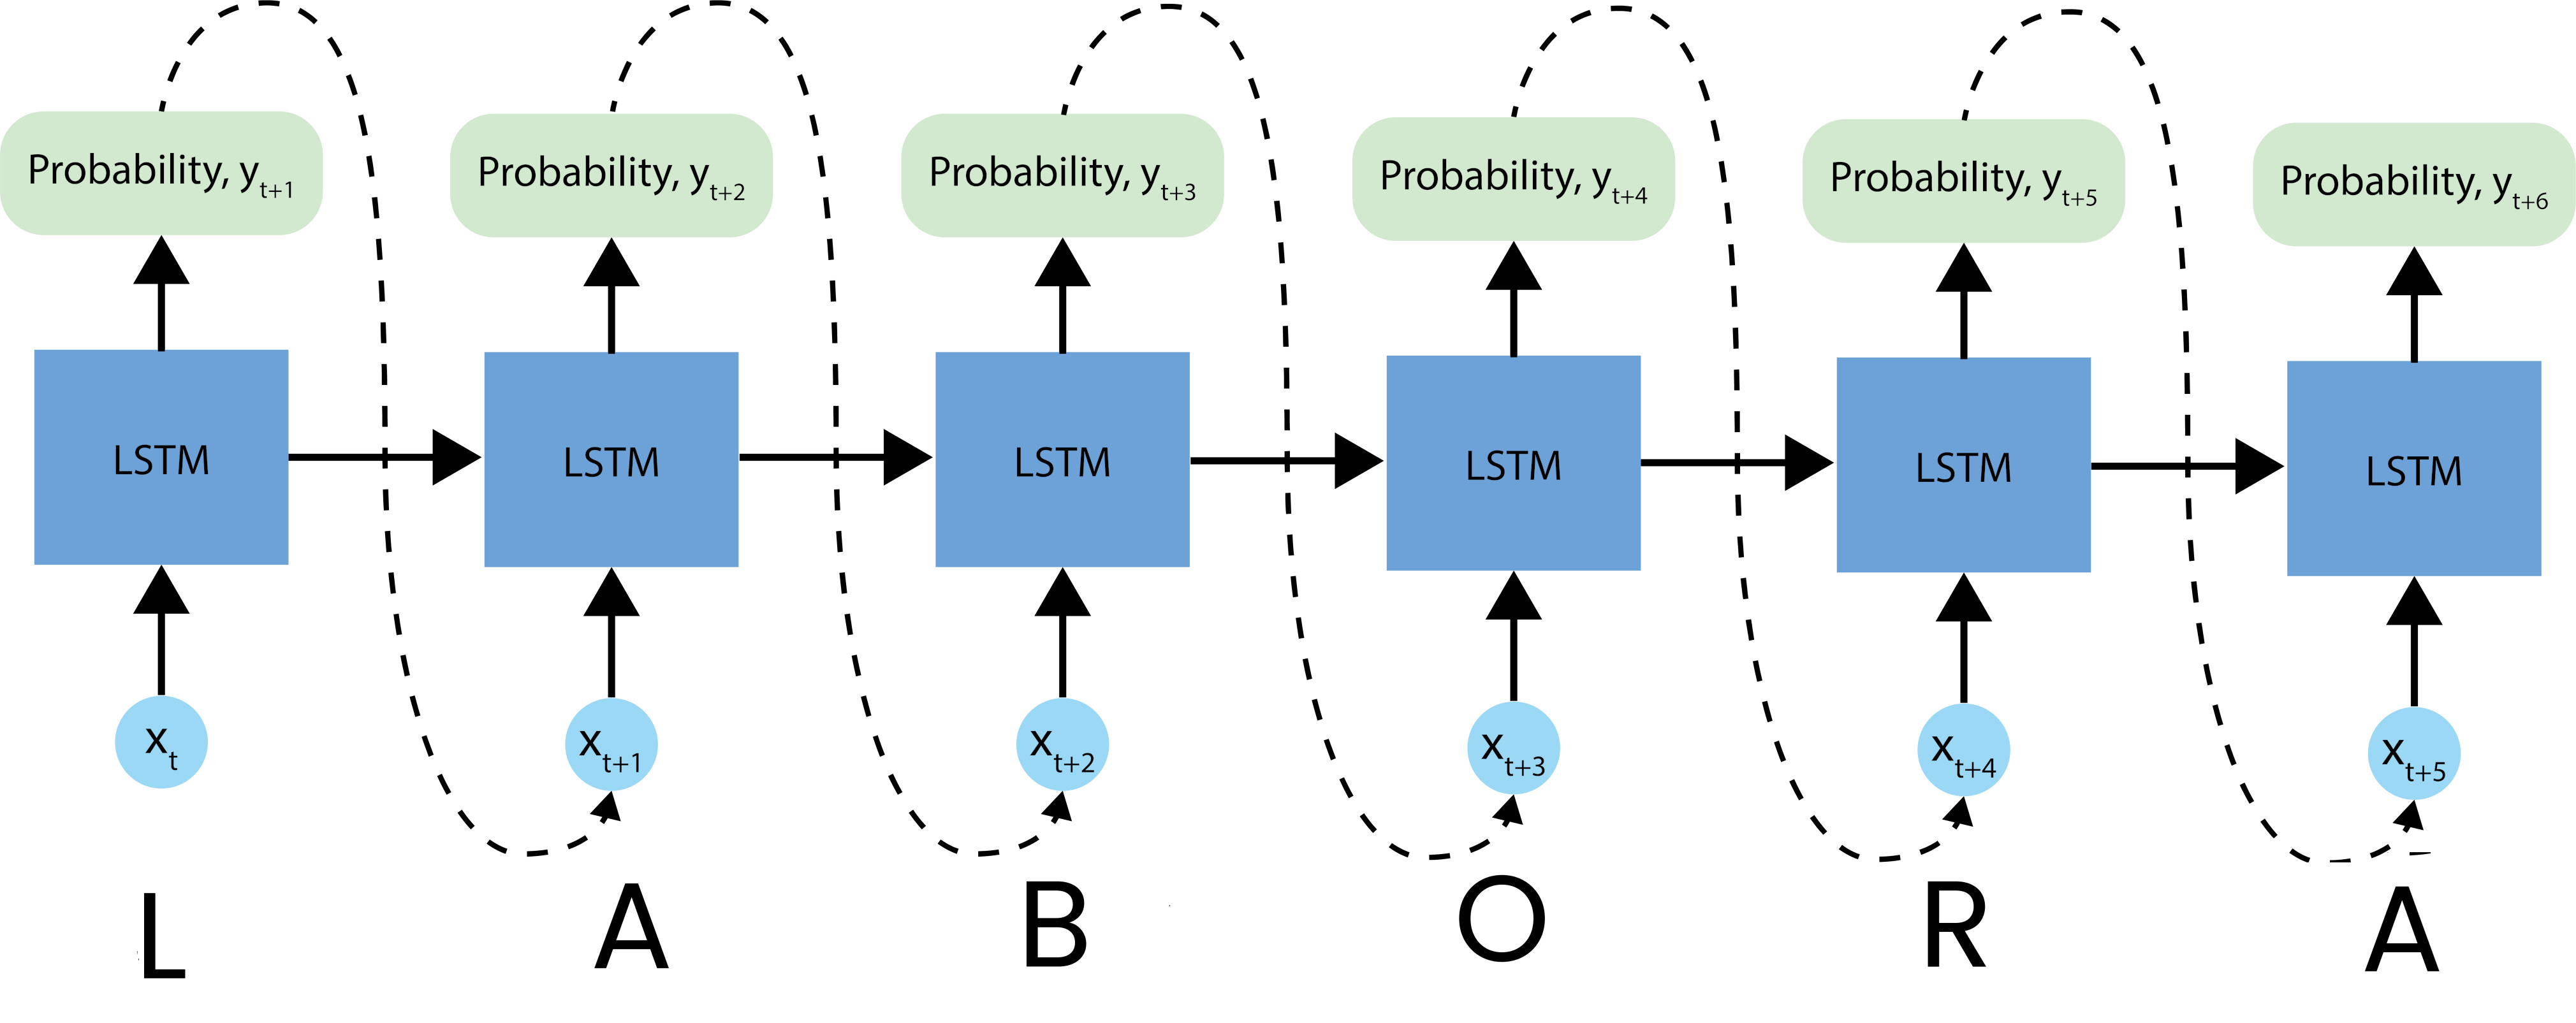

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = ['''TODO''']
  input_eval = torch.tensor(input_eval, dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)

  # Empty string to store our results
  text_generated = []

  model.eval()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      with torch.no_grad():
          predictions, _ = model('''TODO''')

      # Remove batch dimension and apply softmax to get probabilities
      predictions = predictions[:, -1, :]  # Shape: (1, vocab_size)
      probabilities = torch.softmax(predictions, dim=-1).cpu()

      # Sample the next character index from the multinomial distribution
      predicted_id = torch.multinomial(probabilities, num_samples=1).item()

      # Use the predicted character for the next input
      input_eval = torch.tensor([[predicted_id]], dtype=torch.long).to(next(model.parameters()).device)

      '''TODO: add the predicted character to the generated text!'''
      text_generated.append('''TODO''')

  return start_string + ''.join(text_generated)

In [ ]:
# Use the model and the function defined above to generate ABC format text of length 1000!
#    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000)

### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

We will save the song to Comet -- you will be able to find your songs under the `Audio` and `Assets & Artificats` pages in your Comet interface for the project. Note the [`log_asset()`](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/Experiment/#experimentlog_asset) documentation, where you will see how to specify file names and other parameters for saving your assets.

In [ ]:
### Play back generated songs ###

generated_songs = utils.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = utils.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)


## 2.7 Experiment !

Congrats on making your first sequence model in PyTorch! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

Consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset?
*  Does the choice of start string significantly affect the result?


Have fun and happy listening!

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)
